## Preprocessing Suara Buka Tutup

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

TRAIN_DIR = "dataset48k/train"
VAL_DIR   = "dataset48k/val"

# Parameter preprocessing
TARGET_SR = 22050         # target sample rate
TARGET_DURATION = 1.0     # target durasi 1 detik
MAX_LEN = int(TARGET_SR * TARGET_DURATION)

In [2]:
def preprocess_audio(file_path, target_sr=TARGET_SR, target_len=MAX_LEN, noise_reduction=True):
    """
    Membaca audio dan mengubah ke bentuk konsisten (sample rate, durasi, normalisasi)
    """
    # 1. Load audio
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # 2. Trim ke durasi tetap (potong / pad)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]
    
    # 3. Normalisasi amplitudo (skala -1 sampai 1)
    y = y / np.max(np.abs(y) + 1e-6)
    
    # 4. Hilangkan noise kecil
    if noise_reduction:
        y[np.abs(y) < 0.005] = 0.0
    
    return y, sr

Sample rate asli: 48000 Hz | Durasi asli: 3.76s
Sample rate baru: 22050 Hz | Durasi baru: 1.00s


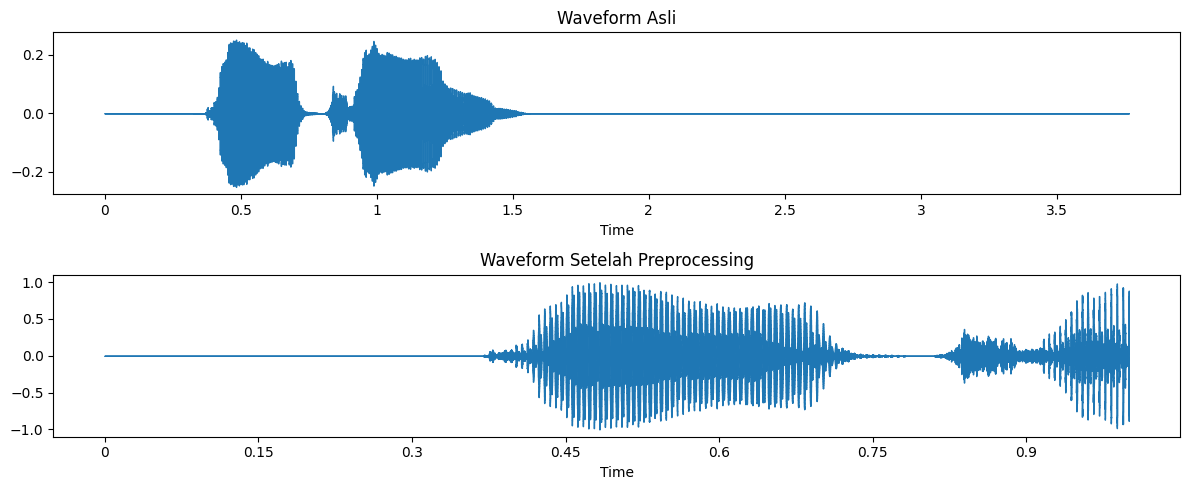

🔊 Sebelum preprocessing:


🔊 Setelah preprocessing:


In [3]:
sample_file = os.path.join(TRAIN_DIR, "buka", os.listdir(os.path.join(TRAIN_DIR, "buka"))[10])

y_raw, sr_raw = librosa.load(sample_file, sr=None)
y_proc, sr_proc = preprocess_audio(sample_file)

print(f"Sample rate asli: {sr_raw} Hz | Durasi asli: {len(y_raw)/sr_raw:.2f}s")
print(f"Sample rate baru: {sr_proc} Hz | Durasi baru: {len(y_proc)/sr_proc:.2f}s")

fig, ax = plt.subplots(2, 1, figsize=(12, 5))
librosa.display.waveshow(y_raw, sr=sr_raw, ax=ax[0])
ax[0].set_title("Waveform Asli")
librosa.display.waveshow(y_proc, sr=sr_proc, ax=ax[1])
ax[1].set_title("Waveform Setelah Preprocessing")
plt.tight_layout()
plt.show()

print("🔊 Sebelum preprocessing:")
ipd.display(ipd.Audio(y_raw, rate=sr_raw))
print("🔊 Setelah preprocessing:")
ipd.display(ipd.Audio(y_proc, rate=sr_proc))

In [4]:
import tqdm

def preprocess_dataset(base_path):
    """
    Membaca seluruh file audio dalam folder dan melakukan preprocessing.
    Menghasilkan list (waveform, label)
    """
    data = []
    for label in os.listdir(base_path):
        folder = os.path.join(base_path, label)
        if not os.path.isdir(folder):
            continue
        for fn in tqdm.tqdm(os.listdir(folder), desc=f"Processing {label}"):
            file_path = os.path.join(folder, fn)
            y, sr = preprocess_audio(file_path)
            data.append((y, label))
    return data

import joblib

train_data = preprocess_dataset(TRAIN_DIR)
val_data   = preprocess_dataset(VAL_DIR)

joblib.dump(train_data, "train_preprocessed.pkl")
joblib.dump(val_data, "val_preprocessed.pkl")

print(f"✅ Total data train: {len(train_data)}, val: {len(val_data)}")

Processing tutup: 100%|██████████| 50/50 [00:00<00:00, 52.84it/s]


✅ Total data train: 300, val: 100


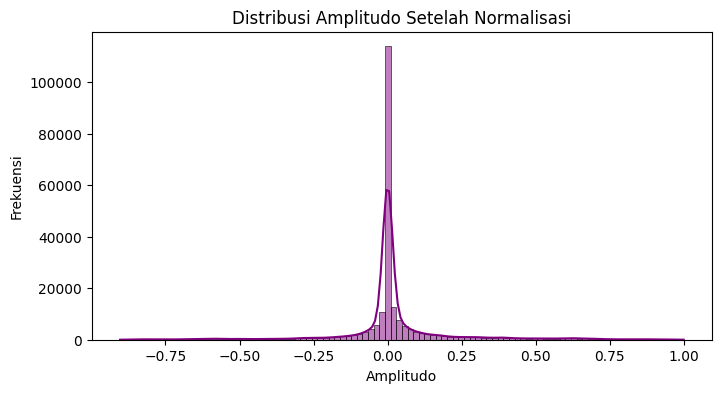

In [5]:
import seaborn as sns

samples = [y for y, _ in train_data[:10]]
amps = np.concatenate(samples)

plt.figure(figsize=(8,4))
sns.histplot(amps, bins=100, color='purple', kde=True)
plt.title("Distribusi Amplitudo Setelah Normalisasi")
plt.xlabel("Amplitudo")
plt.ylabel("Frekuensi")
plt.show()

In [6]:
import numpy as np
import pandas as pd
import librosa
import scipy.stats
import joblib
import tqdm

train_data = joblib.load("train_preprocessed.pkl")
val_data   = joblib.load("val_preprocessed.pkl")

print(f"✅ Data berhasil dimuat. Total train: {len(train_data)}, val: {len(val_data)}")

✅ Data berhasil dimuat. Total train: 300, val: 100


In [7]:
def extract_features(y, sr=22050):
    """
    Mengambil fitur statistik dari sinyal audio 1D (time-series)
    """
    feats = {}
    # Fitur domain waktu
    feats['mean'] = np.mean(y)
    feats['var'] = np.var(y)
    feats['skew'] = scipy.stats.skew(y)
    feats['kurt'] = scipy.stats.kurtosis(y)
    feats['rms'] = np.sqrt(np.mean(y**2))
    feats['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fitur domain frekuensi
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    feats['centroid'] = np.mean(centroid)
    feats['bandwidth'] = np.mean(bandwidth)

    # spectral rolloff & entropy
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    feats['rolloff'] = np.mean(rolloff)
    
    # Entropy sederhana 
    hist, _ = np.histogram(y, bins=50, density=True)
    hist = hist[hist > 0]
    feats['entropy'] = -np.sum(hist * np.log2(hist))

    return feats

In [8]:
def build_feature_dataset(preprocessed_data, sr=22050):
    """
    Mengubah list (waveform, label) menjadi DataFrame fitur statistik
    """
    feature_list = []
    for y, label in tqdm.tqdm(preprocessed_data):
        f = extract_features(y, sr)
        f['label'] = label
        feature_list.append(f)
    return pd.DataFrame(feature_list)

train_features = build_feature_dataset(train_data)
val_features   = build_feature_dataset(val_data)

print("✅ Contoh hasil ekstraksi fitur:")
display(train_features.head())

100%|██████████| 100/100 [00:00<00:00, 137.84it/s]


✅ Contoh hasil ekstraksi fitur:


,mean,var,skew,kurt,rms,zcr,centroid,bandwidth,rolloff,entropy,label
0,0.027930,0.054906,0.310139,4.100600,0.235979,0.028975,866.701761,1047.809331,1705.772261,-35.834524,buka
1,0.019298,0.013794,2.706977,16.686246,0.119022,0.035933,1058.185357,1403.849887,1957.563920,-76.693658,buka
2,0.017041,0.014366,2.951589,18.952388,0.121064,0.035234,1089.114505,1429.448068,2157.235440,-79.108993,buka
3,0.022817,0.016513,2.394192,12.646443,0.130515,0.044334,811.369504,1156.557667,1385.465865,-65.200230,buka
4,0.026553,0.054825,0.299643,4.157365,0.235648,0.028797,963.396500,1217.603421,1896.634743,-36.362223,buka


In [9]:
train_features.to_csv("train_features.csv", index=False)
val_features.to_csv("val_features.csv", index=False)
print("File fitur disimpan: train_features.csv dan val_features.csv")

File fitur disimpan: train_features.csv dan val_features.csv
